In [ ]:
!pip install -q tf-models-official==2.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 11.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from scipy import stats
from matplotlib import pyplot
import numpy as np
import datetime, os
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib
from IPython.display import display, Image, clear_output
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
import math
import h5py
import pickle
import seaborn as sns
import pandas as pd
from official import nlp
import official.nlp.optimization
from tqdm import tqdm
import copy

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# keras

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=8000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
class myScheduler():
    def __init__(self, goal_lr=1e-4, end_lr=1e-5, beta=1e-4, n_epochs=100, w_epochs=10):
        self.goal_lr = goal_lr
        self.end_lr  = end_lr
        self.alpha   = goal_lr/w_epochs
        self.beta    = beta
        self.lr      = goal_lr/w_epochs
        self.w_epochs= w_epochs
    def get_lr(self, epoch):
        if(epoch<self.w_epochs):
            self.lr += self.alpha
        else:
            self.lr -= (np.exp(self.beta*epoch)-self.end_lr)
        return self.lr

# s = myScheduler(1e-4,
#                 1e-5,
#                 1e-4,
#                 100,
#                 20)
# x = np.array([i for i in range(100)])
# y = np.array([s.get_lr(i) for i in x])

# sns.lineplot(x,y)

In [ ]:
def get_angles(pos, i, d_model, c1=10_000):
  angle_rates = 1 / np.power(c1, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model, c1=10_000):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model,
                          c1)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
def tss_positional_encoding(position, d_model, tss):
#   angle_rads = get_angles(np.abs(np.arange(position)-tss)[:, np.newaxis],
#                           np.arange(d_model)[np.newaxis, :],
#                           d_model)
    angle_rads = get_angles((np.arange(position)-tss)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
# tpe = tss_positional_encoding(666, 32, 666//2)
# fig, ax = plt.subplots(figsize=(100,50))
# ax.matshow(tpe[0])

In [ ]:
class CustomMultiHeadAttentionTFP(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(CustomMultiHeadAttentionTFP, self).__init__()
        self.num_heads = num_heads
        self.d_model = key_dim
        assert key_dim % self.num_heads == 0
        self.depth = key_dim // self.num_heads

        self.wq = layers.Dense(num_heads*key_dim)
        self.wk = layers.Dense(num_heads*key_dim)
        self.wv = layers.Dense(num_heads*key_dim)

        self.dense = layers.Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_model))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            mask = tf.ones(tf.shape(mask)) - mask
            mask = tf.expand_dims(mask, axis=1)
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, q, k, v, return_attention_scores=False, attention_mask=None):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        output, attention_weights = self.scaled_dot_product_attention(q, k, v, attention_mask)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.num_heads*self.d_model))

        output = self.dense(output)
        if return_attention_scores==True:
            return output, attention_weights
        else:
            return output

In [ ]:
class CustomMultiHeadAttentionTFPConv(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(CustomMultiHeadAttentionTFPConv, self).__init__()
        self.num_heads = num_heads
        self.d_model = key_dim
        assert key_dim % self.num_heads == 0
        self.depth = key_dim // self.num_heads

        self.wq = layers.Dense(num_heads*key_dim)
        self.wk = layers.Dense(num_heads*key_dim)
        self.wv = layers.Dense(num_heads*key_dim)

        self.conv = layers.Conv1D(filters=key_dim, kernel_size=9, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')
        self.avg = layers.AveragePooling1D(pool_size=4, strides=None, padding="valid")



        self.dense = layers.Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.d_model))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            mask = tf.ones(tf.shape(mask)) - mask
            mask = tf.expand_dims(mask, axis=1)
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, q, k, v, return_attention_scores=False, attention_mask=None):
        batch_size = tf.shape(q)[0]

        ck = self.conv(k)
        k = k + ck
        k = self.avg(k)

        cv = self.conv(v)
        v = v + cv
        v = self.avg(v)

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        output, attention_weights = self.scaled_dot_product_attention(q, k, v, attention_mask)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.num_heads*self.d_model))

        output = self.dense(output)
        if return_attention_scores==True:
            return output, attention_weights
        else:
            return output

In [ ]:
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(CustomMultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = key_dim
        assert key_dim % self.num_heads == 0
        self.depth = key_dim // self.num_heads

        self.wq = layers.Dense(key_dim)
        self.wk = layers.Dense(key_dim)
        self.wv = layers.Dense(key_dim)

        self.dense = layers.Dense(key_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def scaled_dot_product_attention(self, q, k, v, mask):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        d_k = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        if mask is not None:
            mask = tf.ones(tf.shape(mask)) - mask
            mask = tf.expand_dims(mask, axis=1)
            scaled_attention_logits += (mask * -1e9)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def call(self, q, k, v, return_attention_scores=False, attention_mask=None):
        batch_size = tf.shape(q)[0]

        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        output, attention_weights = self.scaled_dot_product_attention(q, k, v, attention_mask)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        output = tf.reshape(output, (batch_size, -1, self.d_model))

        output = self.dense(output)
        if return_attention_scores==True:
            return output, attention_weights
        else:
            return output

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, p_enc="w2v"):
        super(TransformerBlock, self).__init__()
        self.att = CustomMultiHeadAttentionTFP(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.p_enc = p_enc

    def call(self, inputs, masked=None, training=None):
        if self.p_enc == "relative":
            x, x_q, x_k, x_v = inputs
            if masked is not None:
                attn_output, att_scores = self.att(x_q, x_k, x_v, return_attention_scores=True, attention_mask=masked)
            else:
                attn_output, att_scores = self.att(x_q, x_k, x_v, return_attention_scores=True)
            inputs = x
        else:
            if masked is not None:
                attn_output, att_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, attention_mask=masked)
            else:
                attn_output, att_scores = self.att(inputs, inputs, inputs, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), att_scores

In [ ]:
class TransformerBlockRelative(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, p_enc="w2v", max_relative=64):
        super(TransformerBlockRelative, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )

        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.p_enc = p_enc

    def call(self, inputs, masked=None, training=None):
        if self.p_enc == "relative":
            x, x_q, x_k, x_v = inputs
            if masked is not None:
                attn_output, att_scores = self.att(x_q, x_k, x_v, return_attention_scores=True, attention_mask=masked)
            else:
                attn_output, att_scores = self.att(x_q, x_k, x_v, return_attention_scores=True)
            inputs = x
        else:
            if masked is not None:
                attn_output, att_scores = self.att(inputs, inputs, inputs, return_attention_scores=True, attention_mask=masked)
            else:
                attn_output, att_scores = self.att(inputs, inputs, inputs, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), att_scores

In [ ]:
class CrossAttentionBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, p_enc="w2v"):
        super(CrossAttentionBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.p_enc = p_enc

    def call(self, inputs, masked=None, training=None):
        query, key_val = inputs
        if masked is not None:
            attn_output, att_scores = self.att(query, key_val, key_val, return_attention_scores=True, attention_mask=masked)
        else:
            attn_output, att_scores = self.att(query, key_val, key_val, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(query + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output), att_scores

In [ ]:
def fft2d(x, shift_freq=False):
    fft2d = tf.math.real(tf.signal.fft2d(tf.cast(x, tf.complex64)))
    if shift_freq:
        fft2d = tf.signal.fftshift(fft2d, axes=(-1, -2))
    return fft2d

In [ ]:
def fft2d(x, shift_freq=False):
    fft2d = tf.math.real(tf.signal.fft2d(tf.cast(x, tf.complex64)))
    if shift_freq:
        fft2d = tf.signal.fftshift(fft2d, axes=(-1, -2))
    return fft2d

In [ ]:
def fft2dI(x, shift_freq=False):
    fft2dI = tf.math.imag(tf.signal.fft2d(tf.cast(x, tf.complex64)))
    if shift_freq:
        fft2dI = tf.signal.fftshift(fft2dI, axes=(-1, -2))
    return fft2dI

In [ ]:
class FNETBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, rate=0.1, compression=False, shift_freq=False, asymmetric=False):
        super(FNETBlock, self).__init__()
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        # self.dropout1 = layers.Dropout(rate)
        # self.dropout2 = layers.Dropout(rate)
        self.compression = compression
        self.shift_freq  = shift_freq
        self.asymmetric  = asymmetric

    def call(self, inputs, training):
        fft2D = fft2d(inputs, shift_freq=self.shift_freq)
        #fft2D = self.dropout1(fft2D, training=training)
        out1 = self.layernorm1(inputs + fft2D)

        if self.shift_freq:
            if self.compression is not False:
                if self.asymmetric:
                    cut = tf.cast((out1.shape[-2] * self.compression)//2, tf.int32)
                    out1 = out1[:, out1.shape[-2]//2:-cut, :]
                else:
                    cut = tf.cast((out1.shape[-2] * self.compression)//2, tf.int32)
                    out1 = out1[:, cut:-cut, :]
        else:
            if self.compression is not False:
                cut = tf.cast((out1.shape[-2] * (1-self.compression))//2, tf.int32)
                outA = out1[:, :cut+1, :]
                outB = out1[:, -cut-1:, :]
                out1 = tf.concat([outA, outB], 1)

        ffn_output = self.ffn(out1)
        #ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
class ChiBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, rate=0.1, compression=False, shift_freq=False, asymmetric=False):
        super(ChiBlock, self).__init__()
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.ffn2 = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm4 = layers.LayerNormalization(epsilon=1e-6)
        self.compression = compression
        self.shift_freq  = shift_freq

    def call(self, inputs, training):
        fft2D  = fft2d(inputs, shift_freq=self.shift_freq)
        fft2DI = fft2dI(inputs, shift_freq=self.shift_freq)

        out1 = self.layernorm1(inputs + fft2D)
        out2 = self.layernorm3(inputs + fft2DI)

        if self.shift_freq:
            if self.compression is not False:
                cut = tf.cast((out1.shape[-2] * self.compression)//2, tf.int32)
                out1 = out1[:, cut:-cut, :]
                out2 = out2[:, cut:-cut, :]

        ffn_output = self.ffn(out1)
        ffn_output2 = self.ffn2(out2)
        return self.layernorm2(out1 + ffn_output), self.layernorm4(out2 + ffn_output2)

In [ ]:
class TimeSkipFNETBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, rate=0.1, compression=False, shift_freq=False, asymmetric=False):
        super(TimeSkipFNETBlock, self).__init__()
        self.ffn1 = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        if shift_freq:
            self.ffn2 = tf.keras.Sequential(
                [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
            )
            self.ffn3 = tf.keras.Sequential(
                [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
            )
        self.ffn4 = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm4 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm5 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm6 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm7 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm8 = layers.LayerNormalization(epsilon=1e-6)
        self.compression = compression
        self.shift_freq  = shift_freq

    def call(self, inputs, training):
        fft2D = fft2d(inputs, shift_freq=self.shift_freq)
        out1 = self.layernorm1(fft2D)
        ffn_output = self.ffn1(out1)
        finalout = self.layernorm2(out1 + ffn_output)

        if self.shift_freq:
            fft2D = fft2d(finalout, shift_freq=self.shift_freq)
            out1 = self.layernorm3(fft2D)
            ffn_output = self.ffn2(out1)
            finalout = self.layernorm4(out1 + ffn_output)

            fft2D = fft2d(finalout, shift_freq=self.shift_freq)
            out1 = self.layernorm5(fft2D)
            ffn_output = self.ffn3(out1)
            finalout = self.layernorm6(out1 + ffn_output)

        fft2D = fft2d(finalout, shift_freq=self.shift_freq)
        out1 = self.layernorm7(fft2D+inputs)
        ffn_output = self.ffn4(out1)
        finalout = self.layernorm8(out1 + ffn_output)

        return finalout

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
class TokenAndPositionEmbedding2(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding2, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions, tf.expand_dims(positions, axis=0)

In [ ]:
class TokenAndPositionEmbedding3(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, rate=0.1):
        super(TokenAndPositionEmbedding3, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x) + positions
        x = self.dropout(x, training=training)
        return x

In [ ]:
class TokenAndPositionEmbedding4(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, rate=0.1):
        super(TokenAndPositionEmbedding4, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_encoding = positional_encoding(maxlen,
                                            embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.d_model = embed_dim

    def call(self, x, training):
        maxlen = tf.shape(x)[-1]
        x = self.token_emb(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :maxlen, :]
        x = self.dropout(x, training=training)
        return x

In [ ]:
class TokenEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, mask_embedding=False, w2v_init="uniform", pad_to_0=False):
        super(TokenEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim,
                                          embeddings_initializer=w2v_init,
                                          #embeddings_constraint=tf.keras.constraints.UnitNorm(axis=0),
                                          )
        self.mask_embedding = mask_embedding
        self.embed_dim      = embed_dim
        self.pad_to_0       = pad_to_0
    def call(self, x):
        if self.mask_embedding is not False:
            mask = tf.cast(x != self.mask_embedding, np.float32)
        x = self.token_emb(x)
        if self.mask_embedding is not False:
            mask_embedded = tf.tile(tf.expand_dims(mask, -1), [1, 1, self.embed_dim])
            if self.pad_to_0:
                return x*mask_embedded, mask
            else:
                return x, mask
        else:
            return x, tf.zeros([0])

# print("orthogonal")
# embedding = TokenEmbedding(10, 5, 5, mask_embedding=4)
# x = tf.cast(np.random.randint(0, 5, size=(2, 20)), np.float32)
# z, mask = embedding(x)
# print("mask \t\t:", mask)
# print("input \t\t:", x)
# print("embedding \t\t:", z)



In [ ]:
#only new_embedding
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, rate):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        x += self.pos_emb(positions)
        x = self.dropout(x, training=training)
        return x

In [ ]:
#only new_embedding
class PositionEncoding2(layers.Layer):
    def __init__(self, maxlen, embed_dim, rate, tss=None, c1=10_000):
        super(PositionEncoding2, self).__init__()
        if tss == None:
            self.pos_encoding = positional_encoding(maxlen, embed_dim, c1)
        else:
            self.pos_encoding = tss_positional_encoding(maxlen, embed_dim, tss)
        self.dropout = tf.keras.layers.Dropout(rate)
        self.d_model = embed_dim

    def call(self, x, training):
        maxlen = tf.shape(x)[-2]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :maxlen, :]
        x = self.dropout(x, training=training)
        return x

In [ ]:
#only new_embedding
class RelativePositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim, rate):
        super(RelativePositionEmbedding, self).__init__()
        self.pos_emb_q = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.pos_emb_k = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.pos_emb_v = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        maxlen = tf.shape(x)[-2]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        x_q = x + self.pos_emb_q(positions)
        x_k = x + self.pos_emb_k(positions)
        x_v = x + self.pos_emb_v(positions)
        x_q = self.dropout(x_q, training=training)
        x_k = self.dropout(x_k, training=training)
        x_v = self.dropout(x_v, training=training)
        return x, x_q, x_k, x_v

In [ ]:
class ScalarFeatureEmbedder(layers.Layer):
    def __init__(self, vector_dim=8, embed_dim=128):
        super(ScalarFeatureEmbedder, self).__init__()
        self.vector_dim = vector_dim
        self.embed_dim  = embed_dim
        self.vector_emb = layers.Embedding(input_dim=vector_dim, output_dim=embed_dim)

    def call(self, x, training):
        batch_size = tf.shape(x)[0]
        positions = tf.range(start=0, limit=self.vector_dim, delta=1)
        embedded = self.vector_emb(positions)
        zeros = tf.zeros((batch_size, self.vector_dim, self.embed_dim))
        embedded = zeros + embedded
        scaled = tf.expand_dims(x,-1) * embedded
        return scaled

# SFE = ScalarFeatureEmbedder(8,12)
# kernel = np.ones((2,8))
# kernel[1:, :]=0.1
# input = tf.convert_to_tensor(( kernel ))
# out = SFE(input)

# print(input.shape, out.shape)

In [ ]:
class Forward(layers.Layer):
    def __init__(self, name=None):
        super(Forward, self).__init__(name = name)

    def call(self, x, training):
        return x

In [ ]:
class FinalEmbedder(layers.Layer):
    def __init__(self, kernelsMat, poolVec, embed_dim,):
        super(FinalEmbedder, self).__init__()
        self.embedding_network = [[layers.Conv1D(filters=embed_dim, kernel_size=k_size, strides=1, padding="same",
                                dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal') for k_size in kernelsMat[i]] for i in range(len(kernelsMat))]
        self.poolings = [layers.AveragePooling1D(pool_size=pool_size, strides=None, padding="valid") for pool_size in poolVec]
    def call(self, x, training):
        for embedding_level, pooler in zip(self.embedding_network, self.poolings):
            convoluted = []
            for conv in embedding_level:
                convoluted.append(conv(x))
            if len(convoluted) > 0:
                added = layers.Add()([x, *convoluted])
            else:
                added = x
            pooled = pooler(added)
            x = pooled
        return pooled

In [ ]:
class Add_REG(layers.Layer):
    def __init__(self, embed_dim, rate=0.01, name=None):
        super(Add_REG, self).__init__(name = name)
        self.reg_emb = layers.Embedding(input_dim=1, output_dim=embed_dim)
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training):
        REG     = tf.range(start=0, limit=1, delta=1)
        reg_emb = self.reg_emb(REG)
        reg_emb = self.dropout(reg_emb, training=training)
        reg_emb = tf.tile(tf.expand_dims(reg_emb, 0), [tf.shape(x)[0], 1, 1])
        concat  = tf.concat([reg_emb, x], 1)
        return concat

# add_reg = Add_REG(32)
# x = np.random.rand(4,5,32)
# x = tf.cast(np.random.randint(0, 1, size=(4,5,32)), np.float32)
# z = add_reg(x)
# print(z.shape)


In [ ]:
class prepare_AttentionMask(layers.Layer):
    def __init__(self, add_reg, pool_size, name=None):
        super(prepare_AttentionMask, self).__init__(name = name)
        self.add_reg = add_reg
        self.pool_size = pool_size

    def call(self, x, training):
        x = tf.ones(tf.shape(x)) - x
        x = tf.expand_dims(x, -1)
        x = layers.MaxPool1D(pool_size=self.pool_size, strides=None, padding="valid")(x)
        if self.add_reg:
            x = tf.concat([tf.zeros((tf.shape(x)[0], 1, 1)), x], axis=1)
        x = tf.ones(tf.shape(x)) - x
        x = tf.matmul(x, x, transpose_b=True)
        return x

In [ ]:
class blend_buckets(layers.Layer):
    def __init__(self, pool_size, name=None):
        super(blend_buckets, self).__init__(name = name)
        self.pool_size = pool_size

    def call(self, inputs, training):
        x, mask = inputs
        mask = tf.ones(tf.shape(mask)) - mask
        mask = tf.tile(tf.expand_dims(mask, -1), [1, 1, tf.shape(x)[-1]])
        mask = layers.MaxPool1D(pool_size=self.pool_size, strides=None, padding="valid")(mask)
        mask = tf.ones(tf.shape(mask)) - mask
        return x*mask

# print("orthogonal")
# embedding = TokenEmbedding(10, 5, 5, mask_embedding=4)
# x = tf.cast(np.random.randint(0, 5, size=(2, 6)), np.float32)
# z, mask = embedding(x)
# print("mask \t\t:", mask)
# print("input \t\t:", x)
# print("embedding \t\t:", z)
# avg = layers.AveragePooling1D(pool_size=2, strides=None, padding="valid")(z)
# blend = blend_buckets(2)
# result = blend([avg, mask])
# print("result: ", result)

In [ ]:
class add_Channel(layers.Layer):
    def __init__(self, name="add_Channel"):
        super(add_Channel, self).__init__(name = name)

    def call(self, x, training):
        x = tf.expand_dims(x, -1)
        return x

In [ ]:
def single_attentionplot(ax, catt, j, i):
    ax.matshow(catt)
    ax.set_xticks([int((catt.shape[0]-1)*i/6) for i in range(7)])
    ax.set_yticks([int((catt.shape[0]-1)*i/6) for i in range(7)])
    #ax.grid(True, alpha=0.2)
    if i == 0 and j==0:
        ax.set_title(f"Layer{j+1}\nHead{i+1}",pad=20)
    elif i==0:
        ax.set_title(f"Layer{j+1}",pad=20)
    elif j==0:
        ax.set_title(f"Head{i+1}",pad=20)

def attention_plot(atts, epoch, show=True):
    if len(atts)==0:
        return 0
    collapsed_atts = []
    for catts in atts:
        collapsed_atts.append(np.mean(catts, axis=0, keepdims=True))
    n_heads = atts[0].shape[1]
    gene=13
    fig, axs = plt.subplots(len(atts), n_heads, figsize=(30,  int(12*(1+len(atts)/4))), squeeze=False, constrained_layout=True)
    for j, catts in enumerate(collapsed_atts):
        for i in range(n_heads):
            single_attentionplot(axs[j, i], catts[0, i, :, :], j, i)

    fig.suptitle(f'Mean Attention Plot - Epoch: {epoch}', y=0.98)
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(f"/tmp/att_plots/attention_plot_{epoch}")

# atts = np.random.rand(4, 8, 4, 666, 666)
# attention_plot(atts, 1)

In [ ]:
def single_attentionplot_REG(ax, ax_histx, ax_histy, catt, j, i):
    ax.matshow(catt, cmap="viridis")
    ax.set_yticks([int((catt.shape[0]-1)*i/6) for i in range(7)])

    ax_histx.matshow(catt[0:1, :], cmap="viridis")
    ax_histx.set(aspect=(catt.shape[0])/13)
    ax_histy.matshow(catt[:, 0:1], cmap="viridis")
    ax_histy.set(aspect=(13/catt.shape[0]))

    ax_histx.set_xticks([int((catt.shape[0]-1)*i/6) for i in range(7)])
    ax_histx.set_yticks([0])
    ax_histx.set_yticklabels(['[REG]'])

    ax_histy.set_xticks([])
    ax_histy.set_xticklabels([])
    ax_histy.set_yticks([])

    if i == 0 and j==0:
        ax_histx.set_title(f"Layer{j+1}\nHead{i+1}\n",pad=20)
    elif i==0:
        ax_histx.set_title(f"Layer{j+1}\n",pad=20)
    elif j==0:
        ax_histx.set_title(f"Head{i+1}\n",pad=20)
    ax.set_xticks([])

    ########################################################
def attention_plot_REG(atts, epoch, show=True, fontsize=16.0):
    if len(atts)==0:
        return 0
    plt.rcParams.update({'font.size': fontsize})
    collapsed_atts = []
    for catts in atts:
        collapsed_atts.append(np.mean(catts, axis=0, keepdims=True))

    n_heads = atts[0].shape[1]
    matdim = atts[0].shape[2]-1
    gene=13
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.000
    fig = plt.figure(figsize=(10,  10))
    for j, catts in enumerate(collapsed_atts):
        for i in range(n_heads):
            leftslack = 0.8*i
            bottomslack = 0.8*j
            rect_scatter = [left + leftslack,                   bottom - bottomslack,                    width, height]
            rect_histx   = [left + leftslack,                   bottom + height + spacing - bottomslack, width, 0.05]
            rect_histy   = [left + width + spacing + leftslack, bottom - bottomslack,                    0.05,  height]
            ax       = fig.add_axes(rect_scatter)
            ax_histx = fig.add_axes(rect_histx)
            ax_histy = fig.add_axes(rect_histy)
            single_attentionplot_REG(ax, ax_histx, ax_histy, catts[0, i, :, :], j, i)

    fig.suptitle(f'Mean Attention Plot - Epoch: {epoch}')
    if show:
        plt.show()
    else:
        plt.savefig(f"/tmp/att_plots/attention_plot_REG_{epoch}")

# atts = np.random.rand(4, 8, 4, 667, 667)
# attention_plot_REG(atts, 1)

In [ ]:
class projTransformer:
    def __init__(   self,
                    checkpoint_dir="",
                    model_type="best",
                    n_epochs=300,
                    batch_size=32,
                    learning_rate=1e-4,
                    momentum=0.9,
                    maxlen=10500,
                    embed_dim=32,
                    num_heads=4,
                    ff_dim=64,
                    vocab_size=5,
                    dense=64,
                    lr_reduction_epoch=None,
                    dropout_rate=0.1,
                    t_rate = 0.1,
                    patience=20,
                    optimizer="SGD",
                    warmup_steps = 64*20,
                    shuffle = True,
                    loss = "mse",
                    logdir=None,
                    n_layers1=3,
                    n_layers2=0,
                    compression=False,
                    plot_attention=False,
                    k_size = 6,
                    pooler = "global",
                    shift_freq = False,
                    alternate = None,
                    timeskip = False,
                    p_enc="w2v",
                    convDownScale=True,
                    tss=None,
                    pool_size=30,
                    add_reg=False,
                    steps_per_epoch=5,
                    reduction_factor = 5,
                    mask_embedding = False,
                    w2v_init = "uniform",
                    output_neurons = 1,
                    oneHot=False,
                    n_targets=None,
                    cardinality=16_358,
                    normalization = "batch", # "layer" # "batch"
                    chimera = False,
                    halflife=False,
                    asymmetric = False,
                    pad_to_0 = False,
                    DNA_tags = False,
                    w2v_embdim = None,
                    c1_posenc = 10_000,
                    transcr_factors = False,
                    sure = False,
                    ):

        self.checkpoint_dir     = checkpoint_dir
        self.model_type         = model_type
        self.n_epochs           = n_epochs
        self.batch_size         = batch_size
        self.learning_rate      = learning_rate
        self.momentum           = momentum
        self.maxlen             = maxlen
        self.embed_dim          = embed_dim
        self.num_heads          = num_heads
        self.ff_dim             = ff_dim
        self.vocab_size         = vocab_size
        self.dense              = dense
        self.dropout_rate       = dropout_rate
        self.lr_reduction_epoch = lr_reduction_epoch
        self.t_rate             = t_rate
        self.patience           = patience
        self.optimizer          = optimizer
        self.warmup_steps       = warmup_steps
        self.shuffle            = shuffle
        self.logdir             = logdir
        self.loss               = loss
        self.history            = ""
        self.n_layers1          = n_layers1
        self.n_layers2          = n_layers2
        self.compression        = compression
        self.plot_attention     = plot_attention
        self.k_size             = k_size
        self.p_enc              = p_enc
        self.pooler             = pooler
        self.alternate          = alternate
        self.timeskip           = timeskip
        self.shift_freq         = shift_freq
        self.convDownScale      = convDownScale
        self.tss                = tss
        self.pool_size          = pool_size
        self.steps_per_epoch    = steps_per_epoch
        self.add_reg            = add_reg
        self.reduction_factor   = reduction_factor
        self.mask_embedding     = mask_embedding
        self.w2v_init           = w2v_init
        self.output_neurons     = output_neurons
        self.oneHot             = oneHot
        self.n_targets          = n_targets
        self.cardinality        = cardinality
        self.normalization      = normalization
        self.chimera            = chimera
        self.halflife           = halflife
        self.asymmetric         = asymmetric
        self.pad_to_0           = pad_to_0
        self.DNA_tags           = DNA_tags
        self.c1_posenc          = c1_posenc
        self.transcr_factors    = transcr_factors
        self.sure               = sure

        if w2v_embdim == None:
            self.w2v_embdim = embed_dim
        else:
            self.w2v_embdim = w2v_embdim
        if self.chimera==True:
            self.n_layers1 = 1
            self.n_layers2 = 2
        ######################
        self._build_model()
        ######################


        if self.n_layers2 == 0:
            self.plot_attention = False

        #self.learning_rate = tf.Variable(self.learning_rate, trainable=False, name='learning_rate')
        #optimizer
        if self.optimizer == "Adam":
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        if self.optimizer == "SGD":
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, momentum=self.momentum)
        if self.optimizer == "Adadelta":
            self.optimizer = tf.keras.optimizers.Adadelta(learning_rate=self.learning_rate, rho=0.95, epsilon=1e-07, name="Adadelta")
        if self.optimizer == "Adamax":
            self.optimizer = tf.keras.optimizers.Adamax(learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
        if self.optimizer == "Original":
            learning_rate = CustomSchedule(self.embed_dim, self.warmup_steps)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
        if self.optimizer == "BERTAdam":
            # Set up epochs and steps
            train_data_size = self.cardinality
            steps_per_epoch = int(train_data_size / self.batch_size)
            num_train_steps = steps_per_epoch * self.n_epochs
            warmup_steps = int(self.n_epochs * train_data_size * 0.1 / self.batch_size)
            # creates an optimizer with learning rate schedule
            self.optimizer = nlp.optimization.create_optimizer(
                self.learning_rate, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)
        #self.loss =  tf.keras.losses.poisson
        if self.loss == "mse":
            self.loss =  tf.keras.losses.mean_squared_error
        else:
            self.loss =  tf.keras.losses.poisson
        # self.training_loss = tf.keras.metrics.Mean('training_loss', dtype=tf.float32)
        # self.training_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('training_accuracy', dtype=tf.float32)
        # compile
        #self.model.compile(optimizer=optimizer, loss=self.loss)
        #self.model.compile(optimizer=optimizer, loss=custom_loss_function)

    def _build_model(self):
        if self.model_type == "GX-BERT":
            embedding_layer = TokenEmbedding(self.maxlen, self.vocab_size, self.w2v_embdim, self.mask_embedding, self.w2v_init, self.pad_to_0)
            pooler = layers.Dense(self.embed_dim)

            if self.timeskip:
                FBlock = TimeSkipFNETBlock
            elif self.chimera:
                FBlock = ChiBlock
            else:
                FBlock = FNETBlock
            if self.alternate is None:
                fnet_layers  = [FBlock(self.embed_dim, self.ff_dim, self.t_rate, self.compression, self.shift_freq, self.asymmetric) for _ in range(self.n_layers1)]
                trans_layers = [TransformerBlock(self.embed_dim, self.num_heads, self.ff_dim, self.t_rate, self.p_enc) for _ in range(self.n_layers2)]
            else:
                alternate_layers = []
                for _ in range(self.n_layers1):
                    for i, num in enumerate(self.alternate):
                        if i % 2 == 0:
                            for i in range(num):
                                alternate_layers.append(FBlock(self.embed_dim, self.ff_dim, self.t_rate, self.compression, self.shift_freq, self.asymmetric))
                        else:
                            for i in range(num):
                                alternate_layers.append(TransformerBlock(self.embed_dim, self.num_heads, self.ff_dim, self.t_rate, self.p_enc))
            #inputs
            inputs = []


            if self.oneHot:
                input1 = layers.Input(shape=(self.maxlen, 4), name="sequence")
                embedded = layers.Conv1D(filters=self.embed_dim, kernel_size=1, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(input1)
                inputs.append(input1)
            else:
                input1 = layers.Input(shape=(self.maxlen), name="sequence")
                inputs.append(input1)

            if self.halflife:
                halflife = layers.Input(shape=(8), name="halflife")
                inputs.append(halflife)

            if self.DNA_tags:
                DNA_tags = layers.Input(shape=(512), name="dna_tags")
                inputs.append(DNA_tags)
                dna_embedding = layers.Embedding(self.vocab_size, self.embed_dim)
                dna_tags_embedded = dna_embedding(DNA_tags)
                # dna_tags_embedded = layers.BatchNormalization()(dna_tags_embedded)

            if self.transcr_factors:
                transcr_factors = layers.Input(shape=(181), name="transcr_factors")
                inputs.append(transcr_factors)
            if self.sure:
                sure = layers.Input(shape=(1), name="sure")
                inputs.append(sure)

            #embedding
            if self.oneHot == False:
                embedded, masked = embedding_layer(input1)
                if self.w2v_embdim != self.embed_dim:
                    embedded = layers.Conv1D(filters=self.embed_dim, kernel_size=1, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded)


            #cnn layers
            if self.convDownScale:
                if self.k_size == "multiconv":
                    x1 = layers.Conv1D(filters=self.embed_dim, kernel_size=6, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    x2 = layers.Conv1D(filters=self.embed_dim, kernel_size=9, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    skip = layers.Add()([x1, x2, embedded])
                elif  self.k_size == "multiconv_proj":
                    x1 = layers.Conv1D(filters=self.embed_dim, kernel_size=6, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    x2 = layers.Conv1D(filters=self.embed_dim, kernel_size=9, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    x12 = layers.Concatenate()([x1,x2])
                    x12 = layers.Dense(self.embed_dim, activation="relu")(x12)
                    #x12 = layers.Dropout(self.dropout_rate)(x12)
                    skip = layers.Add()([x12, embedded])
                elif  self.k_size == "multiconv_proj_light":
                    x1 = layers.Conv1D(filters=self.embed_dim, kernel_size=6, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    x2 = layers.Conv1D(filters=self.embed_dim, kernel_size=9, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    x1 = layers.Dense(self.embed_dim, activation="relu")(x1)
                    x2 = layers.Dense(self.embed_dim, activation="relu")(x2)
                    #x12 = layers.Dropout(self.dropout_rate)(x12)
                    skip = layers.Add()([x1, x2, embedded])
                elif  self.k_size == "head_conv":
                    x1 = layers.Conv1D(filters=self.embed_dim, kernel_size=6, strides=1, padding="same",
                                    dilation_rate=1, groups=self.num_heads, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    x2 = layers.Conv1D(filters=self.embed_dim, kernel_size=9, strides=1, padding="same",
                                    dilation_rate=1, groups=self.num_heads, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    skip = layers.Add()([x1, x2, embedded])

                else:
                    x = layers.Conv1D(filters=self.embed_dim, kernel_size=self.k_size, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="relu", kernel_initializer='glorot_normal')(embedded) # glorot_normal # glorot_uniform
                    skip = layers.Add()([x, embedded])

                x = layers.AveragePooling1D(pool_size=self.pool_size, strides=None, padding="valid")(skip)
            else:
                x = embedded

            if self.DNA_tags:
                x = layers.Add()([x, dna_tags_embedded])

            if self.normalization == "batch":
                x = layers.BatchNormalization()(x)
            elif self.normalization == "layer":
                x = layers.LayerNormalization()(x)

            posemblen = x.shape[1]
            if self.p_enc == "w2v":
                posenc_layer = PositionEmbedding(posemblen, self.embed_dim, self.t_rate)
            elif self.p_enc == "relative":
                posenc_layer = RelativePositionEmbedding(posemblen, self.embed_dim, self.t_rate)
            else:
                posenc_layer = PositionEncoding2(posemblen, self.embed_dim, self.t_rate, self.tss, self.c1_posenc)

            x = posenc_layer(x)

            # if self.halflife:
            #     SCF = ScalarFeatureEmbedder(8, self.embed_dim)
            #     embedded_halflife = SCF(halflife)
            #     x = layers.Concatenate(axis=1)([x, embedded_halflife])
            # if self.halflife:
            #     embedded_halflife = layers.Dense(self.embed_dim)(halflife)
            #     embedded_halflife = tf.expand_dims(embedded_halflife, axis=1)
            #     x = layers.Concatenate(axis=1)([x, embedded_halflife])
            # M_atts = []
            # if self.halflife:
            #     embedded_halflife = layers.Dense(self.embed_dim)(halflife)
            #     embedded_halflife = tf.expand_dims(embedded_halflife, axis=1)
            #     cab = CrossAttentionBlock(self.embed_dim, self.num_heads, self.ff_dim, self.t_rate, self.p_enc)
            #     crossed_halflife, matts = cab([embedded_halflife, x])
            #     M_atts.append(matts)

            if self.mask_embedding is not False and self.n_layers1==0:
                masked = prepare_AttentionMask(self.add_reg, self.pool_size)(masked)
            else:
                if self.pad_to_0:
                    x = blend_buckets(self.pool_size)([x, masked])
                masked = None

            if self.compression == False:
                if self.add_reg:
                    add_reg = Add_REG(self.embed_dim)
                    x = add_reg(x)

            att_scores = []
            #transformers
            if self.chimera:
                x, x2 = fnet_layers[0](x)
                if self.compression != False:
                    if self.add_reg:
                        x = Add_REG(self.embed_dim)(x)
                        x2 = Add_REG(self.embed_dim)(x2)
                x, atts  = trans_layers[0](x)
                att_scores.append(atts)
                x2, atts = trans_layers[1](x2)
                att_scores.append(atts)
            elif self.alternate is None:
                for i in range(self.n_layers1):
                    x = fnet_layers[i](x)
                ###########################
                if self.compression != False:
                    if self.add_reg:
                        add_reg = Add_REG(self.embed_dim)
                        x = add_reg(x)
                #############################
                for i in range(self.n_layers2):
                    x, atts = trans_layers[i](x, masked=masked)
                    att_scores.append(atts)
            else:
                for layer in alternate_layers:
                    if isinstance(layer, FBlock):
                        x = layer(x)
                    else:
                        x, atts = layer(x, masked=masked)
                        att_scores.append(atts)

            #FC
            if self.pooler == "global":
                if self.chimera:
                    x = layers.GlobalAveragePooling1D()(x)
                    x2 = layers.GlobalAveragePooling1D()(x2)
                    x = layers.Flatten()(x)
                    x2 = layers.Flatten()(x2)
                    x = layers.Concatenate()([x, x2])
                else:
                    x = layers.GlobalAveragePooling1D()(x)
            else: # tanh
                if self.chimera:
                    x = pooler(x[:, 0])
                    x2 = layers.Dense(self.embed_dim)(x2[:, 0])
                    x = layers.Flatten()(x)
                    x2 = layers.Flatten()(x2)
                    x = layers.Concatenate()([x, x2])
                else:
                    x = pooler(x[:, 0])
                    x = tf.keras.activations.tanh(x)


            if self.halflife:
                x = layers.Concatenate()([x, halflife])

            M_atts = []
            #     if self.halflife:
            #     SCF = ScalarFeatureEmbedder(8, self.embed_dim)
            #     embedded_halflife = SCF(halflife)
            #     x = tf.expand_dims(x, axis=1)
            #     x = layers.Concatenate(axis=1)([x, embedded_halflife])
            #     n_tb = 4
            #     tbs = [TransformerBlock(self.embed_dim, self.num_heads, self.ff_dim, self.t_rate, self.p_enc) for _ in range(n_tb)]
            #     add_reg_M = Add_REG(self.embed_dim)
            #     x = add_reg_M(x)
            #     for tb in tbs:
            #         x, matts = tb(x)
            #         M_atts.append(matts)
            #     pooler_M = layers.Dense(self.embed_dim)
            #     x = pooler_M(x[:, 0])
            #     x = tf.keras.activations.tanh(x)
            # if self.halflife:
            #     x = tf.expand_dims(x, axis=1)
            #     x = layers.Concatenate(axis=1)([x, embedded_halflife, crossed_halflife])
            #     x = layers.Flatten()(x)

            if self.transcr_factors:
                x = layers.Concatenate()([x, transcr_factors])
            if self.sure:
                x = layers.Concatenate()([x, sure])

            # x = layers.Flatten()(x)
            #x = layers.Concatenate()([x, input2])
            #dense1
            x = layers.Dense(self.dense, activation="relu")(x)
            x = layers.Dropout(self.dropout_rate)(x)
            #dense2
            x = layers.Dense(self.dense, activation="gelu")(x)
            x = layers.Dropout(self.dropout_rate)(x)
            #output
            if self.n_targets == None:
                output = layers.Dense(self.output_neurons, activation="linear", name="Regression_Output")(x)
            else:
                x = add_Channel()(x)
                output = layers.Conv1D(filters=self.n_targets, kernel_size=1, strides=1, padding="same",
                                    dilation_rate=1, groups=1, activation="softplus", kernel_initializer='glorot_normal')(x)

            print("model built")

            if len(att_scores) > 0:
                #att_scores = Forward(name="att_scores")(att_scores)
                self.model = tf.keras.Model(
                    inputs=inputs,
                    outputs={'Regression_Output': output, 'Attention_Scores': att_scores
                            #  , 'M_atts': M_atts
                             },
                    )
            else:
                self.model = tf.keras.Model(
                    inputs=inputs,
                    outputs={'Regression_Output': output},
                    )
            self.model.summary()
            img = tf.keras.utils.plot_model(self.model, f"{self.model_type}.png", show_shapes=True)
            display(img)

        print(f"\nParameters:\n")
        for k, v in vars(self).items():
            pad = ' '.join(['' for _ in range(25-len(k))])
            print(k, f" :{pad}", v)


    def train_model(self, x_train, x_val, TPU=False, cardinality=16_000, strategy=None, show_att=True):

        def create_step_function(model, optimizer):
            @tf.function
            def train_step(batch, head='Regression_Output', optimizer_clip_norm_global=0.2):
                with tf.GradientTape() as tape:
                    inputs = [batch['sequence']]
                    if self.halflife:
                        inputs.append(batch['halflife'])
                    if self.DNA_tags:
                        inputs.append(batch['dna_tags'])
                    if self.transcr_factors:
                        inputs.append(batch['transcr_factors'])
                    if self.sure:
                        inputs.append(batch['sure'])

                    outputs     = model(inputs, training=True)[head]
                    vec_loss    = self.loss(batch['target'], outputs)
                    loss        = tf.reduce_mean(vec_loss)

                gradients = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(gradients, model.trainable_variables))  #   skip_gradients_aggregation=False

                return vec_loss, outputs
            return train_step

        def eval_step_function(model):
            @tf.function
            def eval_step(batch, head='Regression_Output', optimizer_clip_norm_global=0.2):
                inputs = [batch['sequence']]
                if self.halflife:
                    inputs.append(batch['halflife'])
                if self.DNA_tags:
                    inputs.append(batch['dna_tags'])
                if self.transcr_factors:
                    inputs.append(batch['transcr_factors'])
                if self.sure:
                    inputs.append(batch['sure'])

                outputs     = model(inputs, training=False)
                if self.plot_attention:
                    att_scores  = outputs['Attention_Scores']
                    # m_atts = outputs['M_atts']
                else:
                    att_scores = None
                    # m_atts = None
                vec_loss    = self.loss(batch['target'], outputs[head])
                return vec_loss, att_scores
            return eval_step

        train_step = create_step_function(self.model, self.optimizer)
        eval_step  = eval_step_function(self.model)
        # Train the model
        print("cardinality", cardinality)
        steps_per_epoch = cardinality//self.batch_size
        train_data_it   = iter(x_train)

        global_step = 0
        lowest_val_loss = np.Inf
        patience_counter = 0

        STOP = False

        #first attention plot
        if self.plot_attention:
            batch_val = next(iter(x_val))
            if strategy is None:
                _, att_sco = eval_step(batch_val)
            else:
                _, att_sco = strategy.run(eval_step, args=(batch_val,))
                att_sco       = strategy.gather(att_sco, axis=None)
                # m_atts        = strategy.gather(m_atts, axis=None)
            if self.add_reg:
                attention_plot_REG(att_sco, 0, show_att)
                # attention_plot_REG(m_atts, 0, show_att)
            else:
                attention_plot(att_sco, 0, show_att)
                # attention_plot_REG(m_atts, 0, show_att)

        self.history = {'train_loss' : [], 'val_loss': [], 'epoch': []}
        hasattrNumpy = hasattr(self.optimizer.learning_rate, 'numpy')
        # training
        for epoch_i in range(self.n_epochs):
            if STOP:
                break
            print("\n", f'Epoch: {epoch_i+1}',)
            train_loss_vec = []
            val_loss_vec   = []
            # lr scheduler
            if epoch_i == self.lr_reduction_epoch:
                if hasattrNumpy:
                    self.learning_rate = self.learning_rate/self.reduction_factor
                    self.optimizer.learning_rate.assign(self.learning_rate)
                    print("New Learning Rate Assigned: ", self.learning_rate)
            for i in tqdm(range(steps_per_epoch)):
                global_step += 1

                # if global_step > 1:
                #     learning_rate_frac = tf.math.minimum(
                #         1.0, global_step / tf.math.maximum(1.0, num_warmup_steps))
                #     learning_rate.assign(target_learning_rate * learning_rate_frac)

                batch_train = next(train_data_it)
                if strategy is None:
                    train_loss, _     = train_step(batch=batch_train)
                else:
                    train_loss, o     = strategy.run(train_step, args=(batch_train,))
                    train_loss        = strategy.gather(train_loss, axis=0)
                    #print("train_loss: ", train_loss)
                train_loss_vec.append(np.mean(train_loss.numpy()))

            for i, batch_val in enumerate(x_val):
                if strategy is None:
                    loss, att_sco = eval_step(batch_val)
                else:
                    loss, att_sco = strategy.run(eval_step, args=(batch_val,))
                    loss          = strategy.gather(loss, axis=0)
                    att_sco       = strategy.gather(att_sco, axis=None)
                    # m_atts        = strategy.gather(m_atts, axis=None)
                if i == 0:
                    atts = att_sco
                    # matts = m_atts
                val_loss_vec.append(np.mean(loss.numpy()))

            # End of epoch.
            train_loss = round(np.array(train_loss_vec).mean(), 3)
            val_loss   = round(np.array(val_loss_vec).mean(), 3)
            if hasattrNumpy:
                lr = self.optimizer.learning_rate.numpy()
            else:
                lr = self.optimizer.learning_rate(global_step)
            print(
                    '\t\ttrain_loss: %.3f'  %train_loss,
                    '\tval_loss: %.3f'      %val_loss,
                    '\tlearning_rate: %.3E' %lr
                 )
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['epoch'].append(epoch_i)
            # patience
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                lowest_val_loss_epoch = epoch_i+1
                patience_counter = 0
                print("############################################ New lowest_val_loss reached #########################")
                # Saving the model to a path on localhost.
                saved_model_path = "/tmp/tf_save"
                save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
                self.model.save(saved_model_path, options=save_options)
            elif patience_counter == self.patience:
                print(  f"End of training phase - Patience threshold reached",
                        f'\nWeights Restored from Lowest val_loss epoch: {lowest_val_loss_epoch}',
                        f'\nlowest_val_loss: {lowest_val_loss}')
                STOP = True
            else:
                patience_counter += 1
            # attention plot
            if self.plot_attention and epoch_i%10==0:
                if self.add_reg:
                    attention_plot_REG(atts, epoch_i+1, show_att)
                    # attention_plot_REG(matts, epoch_i+1, show_att)
                else:
                    attention_plot(atts, epoch_i+1, show_att)
                    # attention_plot_REG(matts, epoch_i+1, show_att)

        fig, ax = plt.subplots(1, figsize=(20,9))
        ax.plot(self.history['epoch'], self.history['train_loss'], color="tab:blue")
        ax.plot(self.history['epoch'], self.history['val_loss'], color="tab:orange")
        ax.axhline(0.42, 0, len(self.history['epoch']), alpha=0.2)
        ax.axhline(0.40, 0, len(self.history['epoch']), alpha=0.2)
        ax.axhline(0.36, 0, len(self.history['epoch']), alpha=0.2)
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
        ax.set_title('model train vs validation loss')
        blue_patch  = mpatches.Patch(color='tab:blue', label='train')
        orange_patch = mpatches.Patch(color='tab:orange', label='validation')
        patches = [blue_patch, orange_patch]
        plt.legend(handles=patches, loc='upper right')
        fig.show()

    def evaluate_model(self, dataset, head='Regression_Output', strategy = None):
        def test_step_function(model):
            @tf.function
            def test_step(batch, head='Regression_Output', optimizer_clip_norm_global=0.2):
                inputs = [batch['sequence']]
                if self.halflife:
                    inputs.append(batch['halflife'])
                if self.DNA_tags:
                    inputs.append(batch['dna_tags'])
                if self.transcr_factors:
                    inputs.append(batch['transcr_factors'])
                if self.sure:
                    inputs.append(batch['sure'])
                output     = model(inputs, training=False)
                return output[head]
            return test_step

        test_step = test_step_function(self.model)
        predictions  = []
        y            = []
        for batch_test in dataset:
            if strategy is None:
                output          = test_step(batch_test)
                predictions  += list(output.numpy().flatten())
                y            += list(batch_test['target'].numpy().flatten())
            else:
                output          = strategy.run(test_step, args=(batch_test,))
                output          = strategy.gather(output, axis=0)
                batch_test      = strategy.gather(batch_test['target'], axis=0)
                predictions  += list(output.numpy().flatten())
                y            += list(batch_test.numpy().flatten())

        print('y: ', len(y))
        print('pred: ', len(predictions))
        slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y)
        pearson, _ = stats.mstats.pearsonr(predictions, y)
        print('Test R^2 = %.3f' % r_value**2)
        print('Test Pearson = %.3f' % pearson)
        spearman = stats.spearmanr(predictions, y)[0]
        print('Test Spearman = %.3f' % spearman)
        return predictions, y

    def evaluate_best_model(self, dataset, head='Regression_Output', strategy = None):
        def test_step_function(model):
            @tf.function
            def test_step(batch, head='Regression_Output', optimizer_clip_norm_global=0.2):
                inputs = [batch['sequence']]
                if self.halflife:
                    inputs.append(batch['halflife'])
                if self.DNA_tags:
                    inputs.append(batch['dna_tags'])
                if self.transcr_factors:
                    inputs.append(batch['transcr_factors'])
                if self.sure:
                    inputs.append(batch['sure'])
                output     = model(inputs, training=False)
                return output[head]
            return test_step
        # Loading the model from a path on localhost.
        saved_model_path = "/tmp/tf_save"
        if strategy is not None:
            with strategy.scope():
                load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
                best_model = tf.keras.models.load_model(saved_model_path, options=load_options)
        else:
            load_options = tf.saved_model.LoadOptions(experimental_io_device='/job:localhost')
            best_model = tf.keras.models.load_model(saved_model_path, options=load_options)

        test_step = test_step_function(best_model)
        predictions  = []
        y            = []
        for batch_test in dataset:
            if strategy is None:
                output          = test_step(batch_test)
                predictions  += list(output.numpy().flatten())
                y            += list(batch_test['target'].numpy().flatten())
            else:
                output          = strategy.run(test_step, args=(batch_test,))
                output          = strategy.gather(output, axis=0)
                batch_test      = strategy.gather(batch_test['target'], axis=0)
                predictions  += list(output.numpy().flatten())
                y            += list(batch_test.numpy().flatten())

        print('y: ', len(y))
        print('pred: ', len(predictions))
        slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y)
        pearson, _ = stats.mstats.pearsonr(predictions, y)
        print('Test R^2 = %.3f' % r_value**2)
        print('Test Pearson = %.3f' % pearson)
        spearman = stats.spearmanr(predictions, y)[0]
        print('Test Spearman = %.3f' % spearman)
        return predictions, y

    def plot_kde(self, dataset, head='Regression_Output', strategy = None, predictions=None, y=None):
        if predictions == None and y == None:
            predictions, y = self.evaluate_best_model(dataset, head, strategy)
        df = pd.DataFrame({"predictions":predictions, "true":y})
        ax = sns.displot(data=df, kde=True)
        plt.xlabel("Labels")
        plt.show()

    def plot_train(self, references=[0.36, 0.4, 0.42]):
        fig, ax = plt.subplots(1, figsize=(20,9))
        ax.plot(self.history['epoch'], self.history['train_loss'], color="tab:blue")
        ax.plot(self.history['epoch'], self.history['val_loss'], color="tab:orange")
        for ref in references:
            ax.axhline(ref, 0, len(self.history['epoch']), alpha=0.2)
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
        ax.set_title('model train vs validation loss')
        blue_patch  = mpatches.Patch(color='tab:blue', label='train')
        orange_patch = mpatches.Patch(color='tab:orange', label='validation')
        patches = [blue_patch, orange_patch]
        plt.legend(handles=patches, loc='upper right')
        fig.show()


    def plot_r2(self, dataset, head='Regression_Output', strategy = None, predictions=None, y=None, xlabel="Predicted expression level",
                ylabel="Median expression level", font={'family' : 'serif', 'weight' : 'normal', 'size': 24}, rcparams={'mathtext.default': 'regular', 'axes.spines.top': False, 'axes.spines.right': False}):
        plt.rcParams.update(rcparams)
        matplotlib.rc('font', **font)

        if predictions == None and y == None:
            predictions, y = self.evaluate_best_model(dataset, head, strategy)

        slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y)
        predictions = np.array(predictions)
        y = np.array(y)
        values = np.vstack([predictions, y])
        kernel = stats.gaussian_kde(values)(values)

        exp_results = {"predicted": predictions, "labels": y}
        df = pd.DataFrame(exp_results)

        slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y)

        fig, ax = plt.subplots(figsize=(11, 8.5))
        sns.scatterplot(
            data=df,
            x="predicted",
            y="labels",
            c=kernel,
            cmap="viridis",
            ax=ax,
        )
        ax.set_xlabel(f"{xlabel}")
        ax.set_ylabel(f"{ylabel}")
        plt.legend(loc="upper left", title=f"R$^{2}$: {round(r_value**2,3)}, n={format(len(predictions),',d')}", frameon=False)

        value_range = [np.max([np.min(predictions), np.min(y)]), np.min([np.max(predictions), np.max(y)]) ]
        sns.lineplot(x=value_range, y=value_range, ax=ax, c="red")
        plt.show()
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    def plot_r2_deprecated(self, dataset, head='Regression_Output', strategy = None, predictions=None, y=None, ylim=(-1.5,3), xlim=(-1.5,3)):
        if predictions == None and y == None:
            predictions, y = self.evaluate_best_model(dataset, head, strategy)

        slope, intercept, r_value, p_value, std_err = stats.linregress(predictions, y)
        predictions = np.array(predictions)
        y = np.array(y)
        viridis = cm.get_cmap('autumn', 12)
        diff = y - predictions
        diff = np.abs(diff)

        ### plt size
        plt.rcParams["figure.figsize"] = (10,9)
        ### plt fontsize
        plt.rcParams.update({'font.size': 16})

        ### set title
        plt.title("Expression Scatterplot")
        ### plot
        bis = np.arange(-1.5, 3, 2)
        plt.plot(bis, bis,  f"b", alpha=0.3)
        for p, yi, c in zip(predictions, y, diff):
            plt.plot(p, yi,  f".", markersize=10, color=viridis((1.0-c)/1.1))
        ### set ticks
        plt.xticks([i for i in range(-1, 4)])
        plt.yticks([i for i in range(-1, 4)])
        ### set labels
        plt.xlabel("Predicted expression level")
        plt.ylabel("Median expression level")
        ### create legend
        plt.legend(loc="upper right", title=f"r2 = %.3f\n n = 1000" % r_value**2)
        ### set ylim
        if ylim!=None:
            plt.ylim(ylim)
        if xlim!=None:
            plt.xlim(xlim)
        ### grid
        plt.grid(alpha=0.5)
        ### save
        # if self.save:
        #     plt.savefig(f"{self.dir}{self.filename}.png")
        ### show
        plt.show()




    @staticmethod
    def _split_validation_data(x, y, validation_split):
        rand_indexes = np.random.permutation(x.shape[0])
        x = x[rand_indexes]
        y = y[rand_indexes]
        x_validation = x[:int(len(x) * validation_split)]
        y_validation = y[:int(len(x) * validation_split)]
        x_train = x[int(len(x) * validation_split):]
        y_train = y[int(len(x) * validation_split):]
        return x_train, y_train, x_validation, y_validation

    def lr_scheduler(self, epoch, lr):
        if epoch == self.lr_reduction_epoch:
            return lr * 0.2
        else:
            return lr

In [ ]:
# model_type      = "FNET_Final"
# logdir          = None
# loss            = "mse"
# p_enc           = "original"
# pooler          = "tanh"
# n_layers1       = 0
# n_layers2       = 1
# k_size          = "multiconv_proj" # "multiconv"
# shift_freq      = False
# plot_attention  = True
# alternate       = None
# timeskip        = False
# compression     = False
# convDownScale   = True
# tss             = None
# mask_embedding  = 4
# add_reg         = True
# embed_dim       = 128
# ff_dim          = embed_dim*4
# pool_size       = 128
# dense           = 256
# lr              = 5e-5 # 1e-4
# lr_red_epoch    = 30
# reduction_factor= 5
# t_rate          = 0.1    # 0.1
# maxlen=2**14
# n_epochs=300
# batch_size=256

In [ ]:
# net = projTransformer(checkpoint_dir="FNET/", model_type=model_type, n_epochs=n_epochs, batch_size=batch_size, alternate=alternate, add_reg=add_reg, #n_targets=2,
#                       learning_rate=3e-4, patience=20, optimizer="Adam", vocab_size=4, k_size = 9, pooler=pooler, shift_freq=shift_freq, timeskip=timeskip, chimera=False,
#                       lr_reduction_epoch=60, maxlen=maxlen, embed_dim=embed_dim, num_heads=4, ff_dim=ff_dim, dense=256, plot_attention=plot_attention, convDownScale=convDownScale,
#                       dropout_rate=0.1, logdir=logdir, t_rate=0.1, momentum=0.9, loss=loss, n_layers1=n_layers1, n_layers2=n_layers2, compression=compression,
#                       p_enc=p_enc, mask_embedding=4, halflife=True, pad_to_0=True, pool_size=pool_size)

model built
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 sequence (InputLayer)       [(None, 3000)]               0         []                            
                                                                                                  
 token_embedding_3 (TokenEm  ((None, 3000, 32),           128       ['sequence[0][0]']            
 bedding)                     (0,))                                                               
                                                                                                  
 conv1d_4 (Conv1D)           (None, 3000, 32)             6176      ['token_embedding_3[0][0]']   
                                                                                                  
 add_1 (Add)                 (None, 3000, 32)             0         ['conv1d_4[0

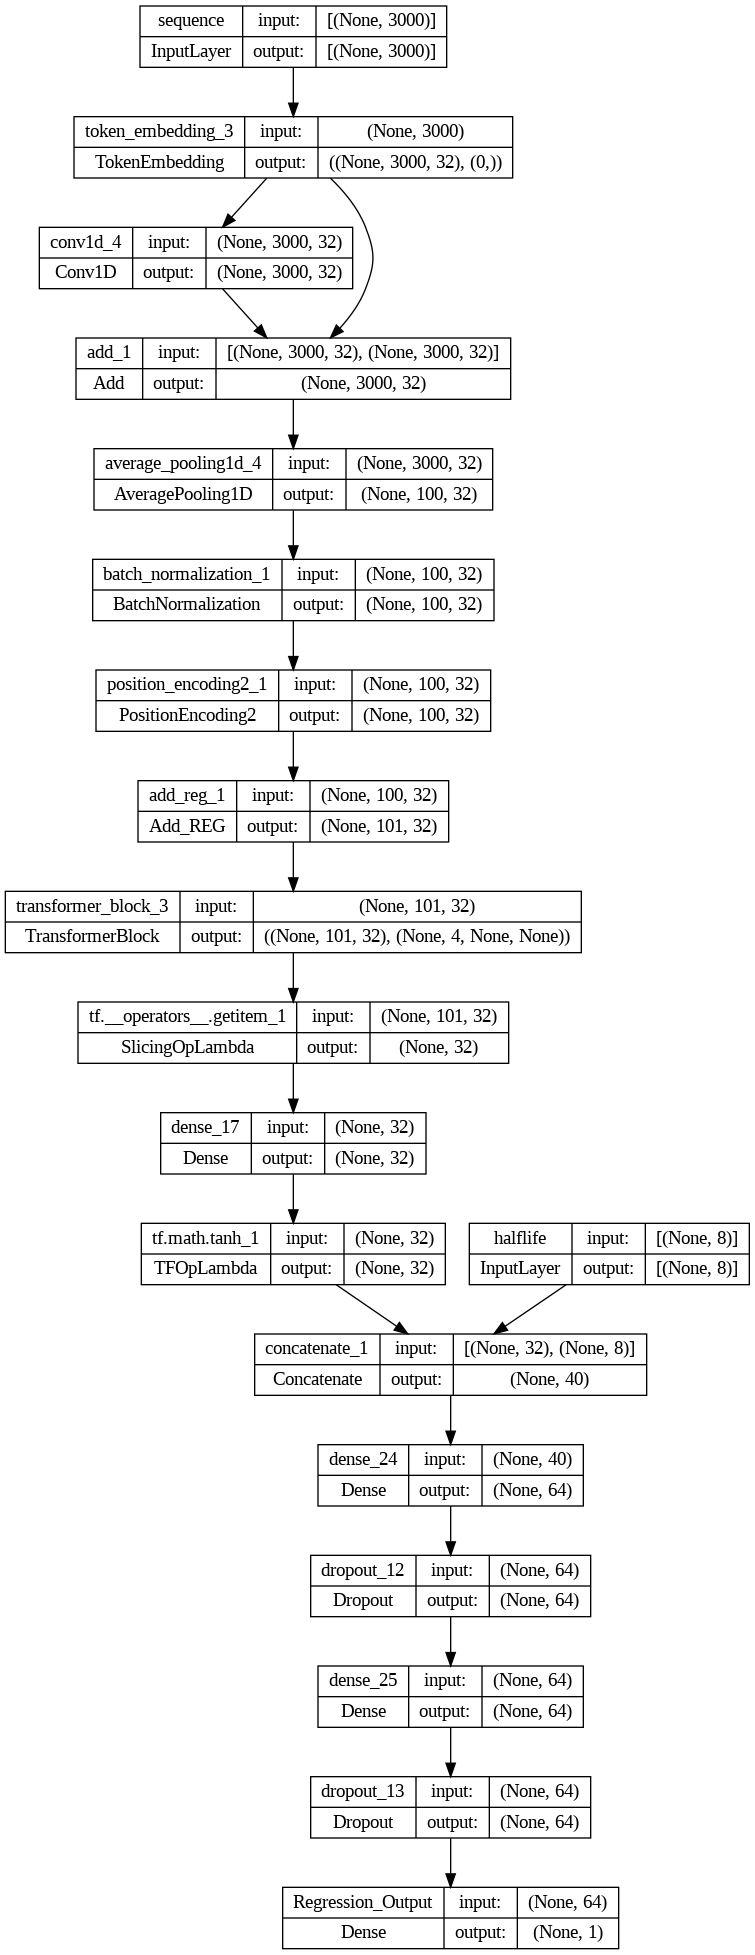


Parameters:

checkpoint_dir  :           FNET/
model_type  :               FNET_Final
n_epochs  :                 2
batch_size  :               256
learning_rate  :            0.0003
momentum  :                 0.9
maxlen  :                   3000
embed_dim  :                32
num_heads  :                4
ff_dim  :                   666
vocab_size  :               4
dense  :                    64
dropout_rate  :             0.1
lr_reduction_epoch  :       60
t_rate  :                   0.1
patience  :                 20
optimizer  :                Adam
warmup_steps  :             1280
shuffle  :                  True
logdir  :                   None
loss  :                     mse
history  :                  
n_layers1  :                0
n_layers2  :                1
compression  :              False
plot_attention  :           True
k_size  :                   6
p_enc  :                    original
pooler  :                   tanh
alternate  :                None
timeskip  :       

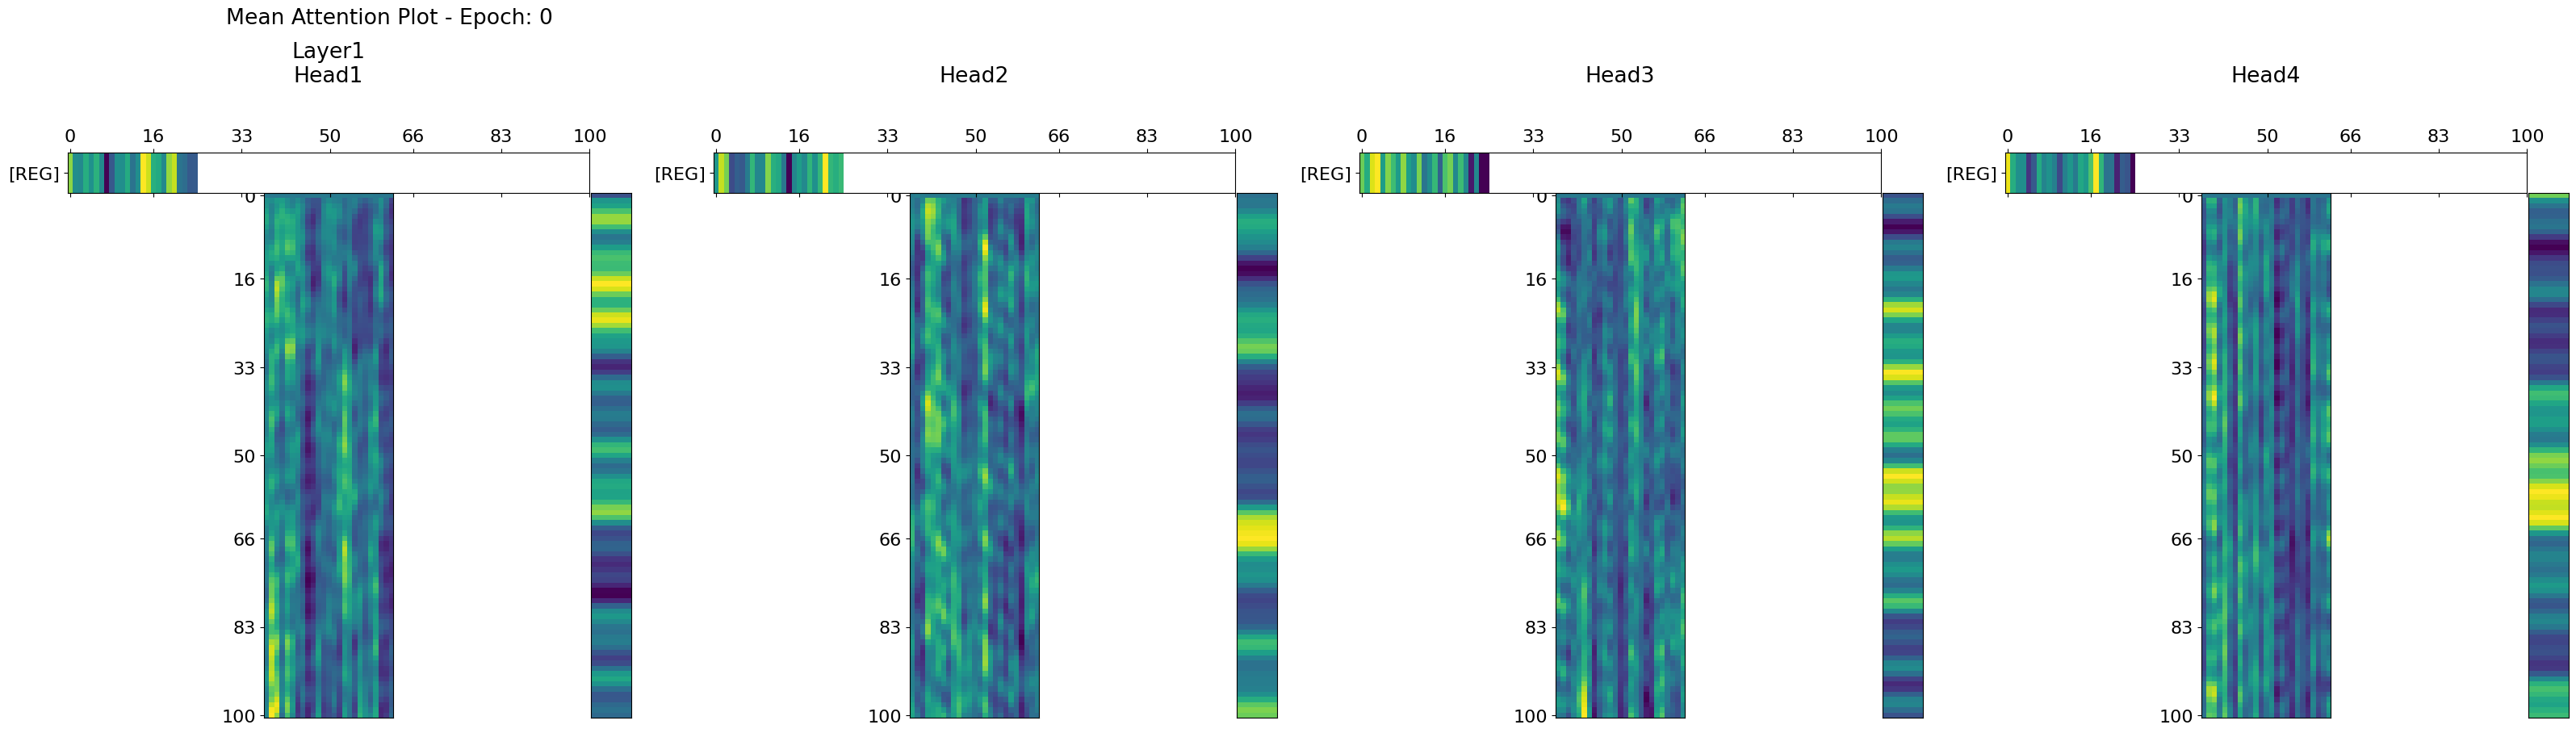


 Epoch: 1


100%|██████████| 3/3 [00:10<00:00,  3.46s/it]


		train_loss: 0.266 	val_loss: 0.100 	learning_rate: 3.000E-04
############################################ New lowest_val_loss reached #########################


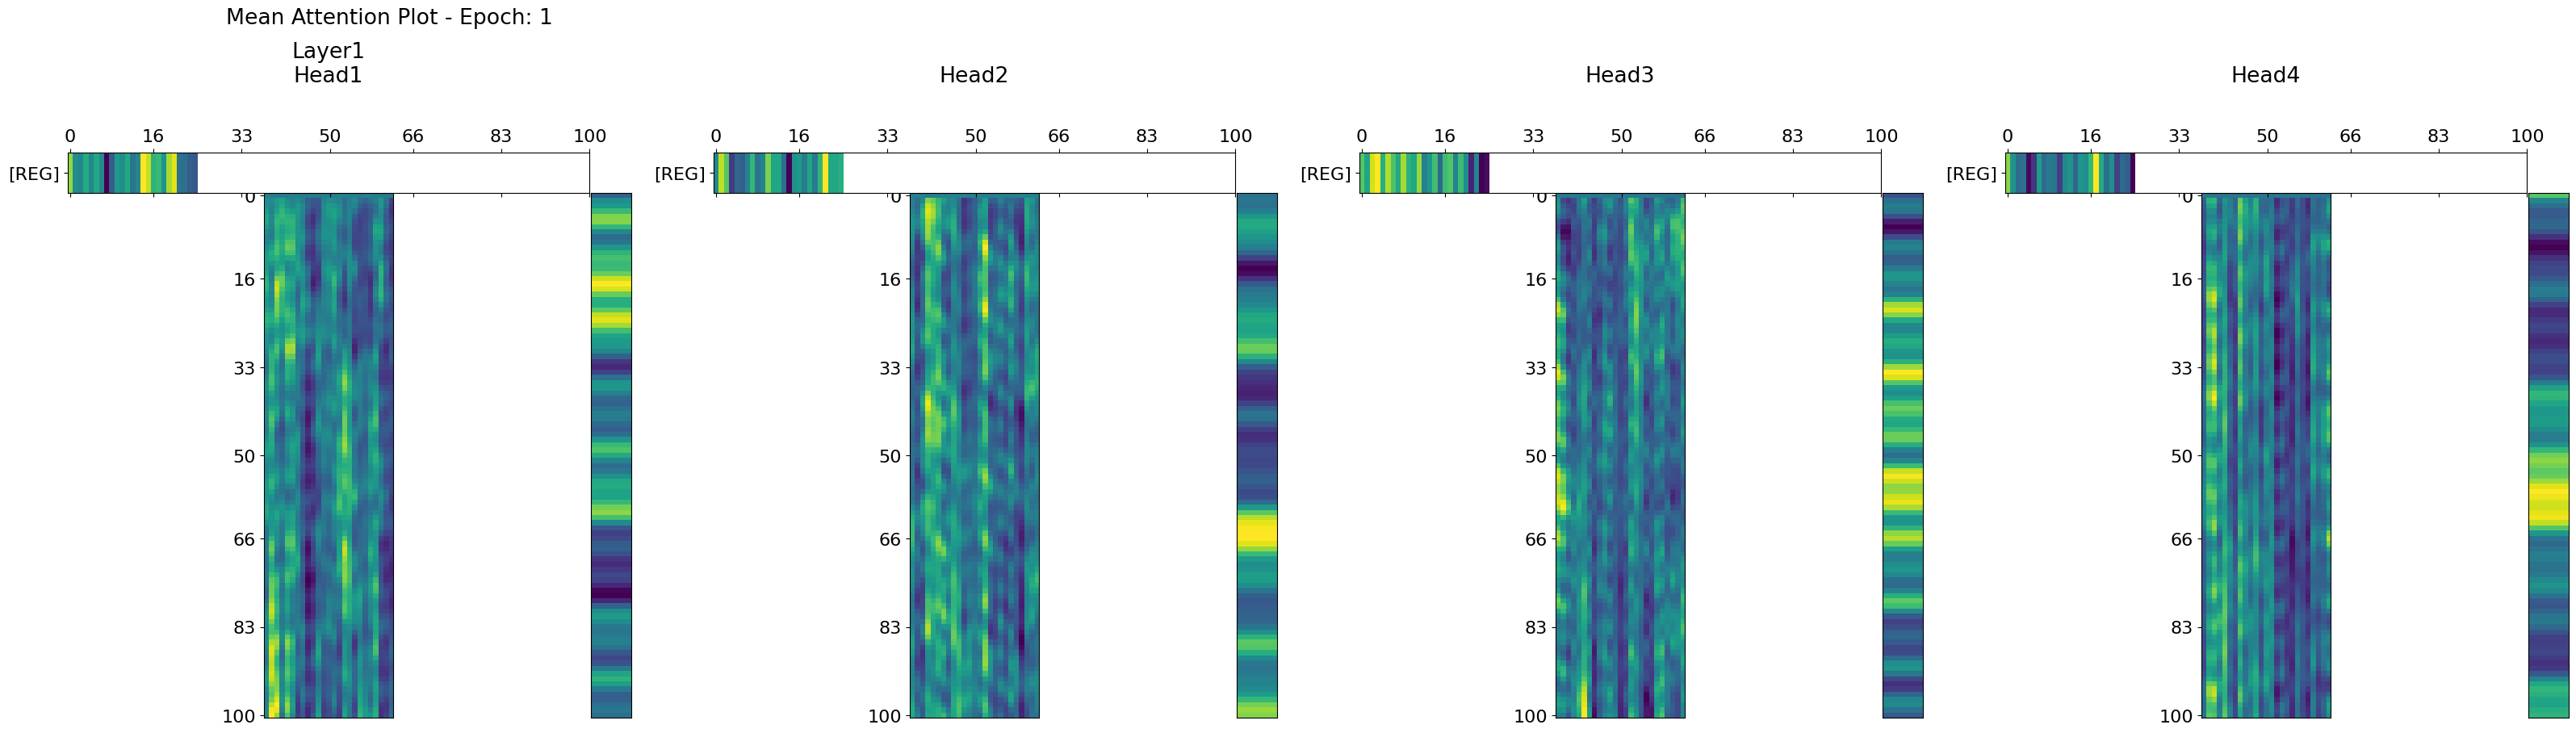


 Epoch: 2


100%|██████████| 3/3 [00:07<00:00,  2.47s/it]


		train_loss: 0.116 	val_loss: 0.103 	learning_rate: 3.000E-04


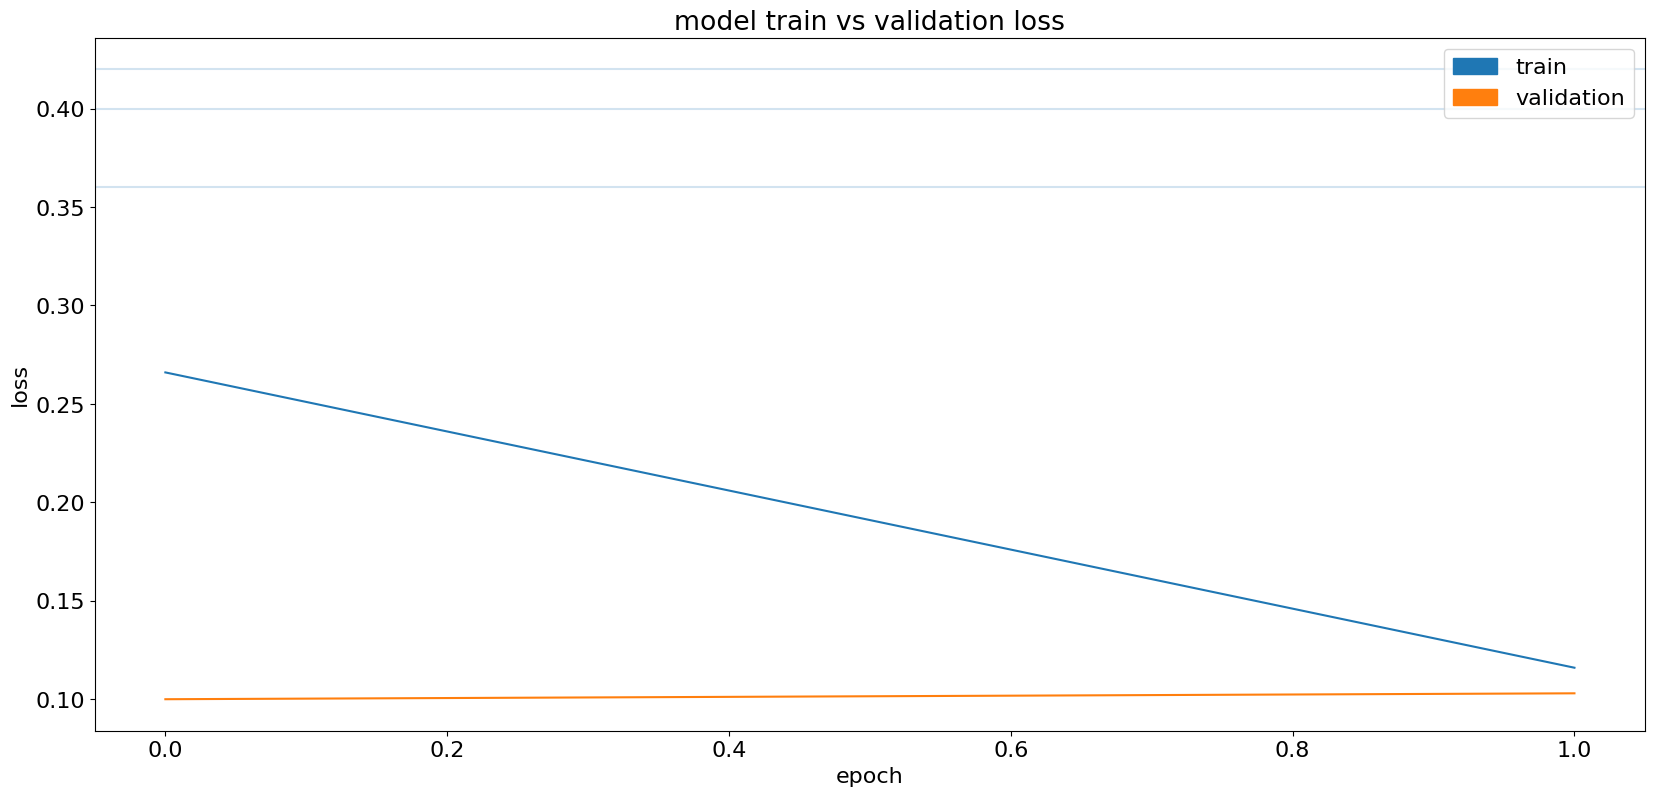

In [ ]:
# maxlen=3000
# model_type      = "FNET_Final"
# logdir          = None
# loss            = "mse"
# p_enc           = "original"
# pooler          = "tanh"
# ff_dim          = 666
# n_layers1       = 0
# n_layers2       = 1
# shift_freq      = False
# plot_attention  = True
# alternate       = None
# timeskip        = False
# compression     = False
# convDownScale   = True
# n_epochs        = 2
# batch_size      = 256
# add_reg         = True
# halflife        = True

# # import tensorflow as tf
# # tf.keras.backend.clear_session()

# # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# # tf.config.experimental_connect_to_cluster(resolver)
# # This is the TPU initialization code that has to be at the beginning.
# # tf.tpu.experimental.initialize_tpu_system(resolver)
# # print("All devices: ", tf.config.list_logical_devices('TPU'))

# # strategy = tf.distribute.TPUStrategy(resolver)

# # with strategy.scope():
# net = projTransformer(checkpoint_dir="FNET/", model_type=model_type, n_epochs=n_epochs, batch_size=batch_size, alternate=alternate, add_reg=add_reg, #n_targets=2,
#                     learning_rate=3e-4, patience=20, optimizer="Adam", vocab_size=4, k_size = 6, pooler=pooler, shift_freq=shift_freq, timeskip=timeskip, chimera=False,
#                     lr_reduction_epoch=60, maxlen=maxlen, embed_dim=32, num_heads=4, ff_dim=ff_dim, dense=64, plot_attention=plot_attention, convDownScale=convDownScale,
#                     dropout_rate=0.1, logdir=logdir, t_rate=0.1, momentum=0.9, loss=loss, n_layers1=n_layers1, n_layers2=n_layers2, compression=compression,
#                     p_enc=p_enc, mask_embedding=False, halflife=True, pad_to_0=False)
# cardinality = 1000

# X_trainpromoter_p    = np.random.randint(0, 3, size=(cardinality, maxlen))
# X_trainhalflife      = np.random.rand(cardinality, 8)
# y_train              = np.random.rand(cardinality)

# X_testpromoter_p    = np.random.randint(0, 3, size=(cardinality, maxlen))
# X_testhalflife      = np.random.rand(cardinality, 8)
# y_test              = np.random.rand(cardinality)

# x_train = tf.data.Dataset.from_tensor_slices(({'sequence': X_trainpromoter_p, 'halflife': X_trainhalflife, 'target': y_train.reshape(-1,1)}))
# x_val   = tf.data.Dataset.from_tensor_slices(({'sequence': X_testpromoter_p, 'halflife': X_testhalflife, 'target': y_test.reshape(-1,1)}))

# x_train = x_train.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE).repeat()
# x_val   = x_val.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# net.train_model(x_train, x_val, False, cardinality=cardinality)

In [ ]:
# maxlen=3000

In [ ]:
# model_type      = "FNET_Final"
# logdir          = None
# loss            = "mse"
# p_enc           = "original"
# pooler          = "tanh"
# ff_dim          = 666
# n_layers1       = 0
# n_layers2       = 1
# shift_freq      = False
# plot_attention  = True
# alternate       = None
# timeskip        = False
# compression     = False
# convDownScale   = True
# n_epochs        = 2
# batch_size      = 256
# add_reg         = True
# halflife        = True

In [ ]:
# net = projTransformer(checkpoint_dir="FNET/", model_type=model_type, n_epochs=n_epochs, batch_size=batch_size, alternate=alternate, add_reg=add_reg, #n_targets=2,
#                       learning_rate=3e-4, patience=20, optimizer="Adam", vocab_size=4, k_size = 6, pooler=pooler, shift_freq=shift_freq, timeskip=timeskip, chimera=False,
#                       lr_reduction_epoch=60, maxlen=maxlen, embed_dim=32, num_heads=4, ff_dim=ff_dim, dense=64, plot_attention=plot_attention, convDownScale=convDownScale,
#                       dropout_rate=0.1, logdir=logdir, t_rate=0.1, momentum=0.9, loss=loss, n_layers1=n_layers1, n_layers2=n_layers2, compression=compression,
#                       p_enc=p_enc, mask_embedding=False, halflife=True, pad_to_0=False)

NameError: name 'maxlen' is not defined

In [ ]:
# cardinality = 1000

# X_trainpromoter_p    = np.random.randint(0, 3, size=(cardinality, maxlen))
# X_trainhalflife      = np.random.rand(cardinality, 8)
# y_train              = np.random.rand(cardinality)

# X_testpromoter_p    = np.random.randint(0, 3, size=(cardinality, maxlen))
# X_testhalflife      = np.random.rand(cardinality, 8)
# y_test              = np.random.rand(cardinality)

# x_train = tf.data.Dataset.from_tensor_slices(({'sequence': X_trainpromoter_p, 'halflife': X_trainhalflife, 'target': y_train.reshape(-1,1)}))
# x_val   = tf.data.Dataset.from_tensor_slices(({'sequence': X_testpromoter_p, 'halflife': X_testhalflife, 'target': y_test.reshape(-1,1)}))

# x_train = x_train.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE).repeat()
# x_val   = x_val.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

# net.train_model(x_train, x_val, False, cardinality=cardinality)

In [ ]:
# net.evaluate_model(x_val)
# print("")
# # net.plot_kde(x_val)
# # print("")
# # net.plot_r2(x_val)
# # print("")

In [ ]:
# masked = tf.concat([tf.cast(np.random.randint(1, 2, size=(1, 4)), np.float32), tf.cast(np.random.randint(0, 1, size=(1, 4)), np.float32),
#                     tf.cast(np.random.randint(1, 2, size=(1, 2)), np.float32)], -1)
# masked = tf.concat([tf.cast(np.random.randint(1, 2, size=(1, 10)), np.float32), masked], 0)
# print("1", masked)
# # masked = tf.ones(tf.shape(masked)) - masked
# # print(masked)


# masked = tf.ones(tf.shape(masked)) - masked
# print("2", masked)
# masked = tf.expand_dims(masked, -1)
# print("3", masked)
# masked = layers.MaxPool1D(pool_size=2, strides=None, padding="valid")(masked)
# print("4", masked)
# masked = tf.ones(tf.shape(masked)) - masked
# print("5", masked)
# tf.matmul(masked, masked, transpose_b=True)
# # masked = tf.expand_dims(masked, 1)
# # print("6", masked)
# # masked = tf.tile(masked, [1, 4, 1, tf.shape(masked)[2]])
# # print("7", masked)